<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/added_new_dataset/notebooks/CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!git clone -b added_new_dataset https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


# CNN Transfer Learning for Visual Emotion Recognition

This notebook demonstrates how to implement transfer learning with CNN networks for visual emotion recognition. We'll use a pre-trained VGG16 model and fine-tune it for our emotion classification task.

## What is Transfer Learning?
Transfer learning is a machine learning technique where we use a model that has been trained on one task and adapt it for a related task. In our case, we'll use a CNN pre-trained on ImageNet and adapt it for emotion recognition.

## Benefits of Transfer Learning:
1. **Faster training**: We start with pre-trained weights instead of random initialization
2. **Better performance**: Especially when we have limited training data
3. **Lower computational requirements**: Less training time needed
4. **Proven feature extractors**: Pre-trained networks have learned robust low-level features

## Step 1: Import Required Libraries

### Upgrade Summary (Targeting >=80% Accuracy)

Improvements applied:
- Stronger backbone: ResNet50 (better feature extraction)
- Progressive unfreezing (stabilize then fine-tune)
- Advanced augmentations: rotation, flip, optional AutoAugment, RandomErasing
- MixUp (alpha=0.4) + Label Smoothing (0.05) for regularization
- Class imbalance handling via dynamic class weights
- Cosine Annealing with Warm Restarts scheduler
- Separate LRs (backbone vs head) + AdamW optimizer
- Gradient clipping (1.0) to avoid exploding gradients
- Balanced accuracy monitoring (robust under class imbalance)

Run all cells sequentially for the improved training pipeline. Adjust CONFIG as needed.

In [16]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Sklearn for metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


In [ ]:
# Configuration & Hyperparameters for Improved Accuracy (target >=80%)
CONFIG = {
    'backbone': 'resnet50',              # stronger backbone than VGG16
    'pretrained': True,
    'freeze_initial_epochs': 2,          # freeze backbone first few epochs (stabilize new head)
    'epochs': 30,
    'patience': 6,                       # early stopping patience
    'batch_size': 64,
    'base_backbone_lr': 1e-4,            # small LR for backbone
    'head_lr': 1e-3,                     # larger LR for new head
    'weight_decay': 1e-4,
    'scheduler': 'cosine_warm_restarts', # cosine schedule with restarts
    'cosine_T0': 5,
    'cosine_Tmult': 2,
    'mixup_alpha': 0.4,                  # MixUp regularization (set 0 to disable)
    'label_smoothing': 0.05,             # label smoothing in CrossEntropy
    'use_class_weights': True,           # handle class imbalance
    'grad_clip': 1.0,                    # gradient clipping max norm
    'use_random_erasing': True,          # additional augmentation
    'random_erasing_p': 0.25,
    'use_autoaugment': False,            # can enable if dataset large enough
    'balanced_metric': True              # compute balanced accuracy
}
print('Loaded CONFIG:', CONFIG)


## Step 2: Data Preparation

First, let's set up our data paths and load the dataset splits.

In [ ]:
# Data paths (modify these if running locally)
from collections import Counter

if 'PROJECT_ROOT' not in globals():
    PROJECT_ROOT = Path('/content/ann-visual-emotion') if (Path('/content').exists()) else Path.cwd().parent

CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
DATA_DIR = PROJECT_ROOT / 'data/raw/EmoSet'

print("Checking data files...")
for path in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH]:
    print(('✓ Found' if path.exists() else '✗ Missing') + f': {path}')

# Load label map if it exists
if LABEL_MAP_PATH.exists():
    with open(LABEL_MAP_PATH, 'r') as f:
        label_map = json.load(f)
    num_classes = len(label_map)
    print(f'Number of emotion classes: {num_classes}')
    print(f'Emotion classes: {list(label_map.keys())}')
else:
    # Fallback dummy map
    label_map = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6}
    num_classes = len(label_map)
    print(f'Using dummy label map with {num_classes} classes: {list(label_map.keys())}')

# Optional: compute class weights for imbalance handling (used later)
class_weights = None
if CSV_TRAIN.exists() and CONFIG.get('use_class_weights', False):
    try:
        _df_tmp = pd.read_csv(CSV_TRAIN)
        # Identify label column
        possible_label_cols = [c for c in _df_tmp.columns if 'label' in c.lower() or 'class' in c.lower() or 'emotion' in c.lower()]
        label_col = possible_label_cols[0] if possible_label_cols else _df_tmp.columns[1]
        counts = Counter(_df_tmp[label_col])
        print('Class counts:', counts)
        # Map counts to indices
        inv_label_map = {k: v for k, v in label_map.items()}
        freq_per_index = {inv_label_map[k]: counts[k] for k in counts if k in inv_label_map}
        max_count = max(freq_per_index.values())
        weights = [max_count / freq_per_index.get(i, max_count) for i in range(num_classes)]
        class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
        print('Computed class weights:', weights)
    except Exception as e:
        print('Could not compute class weights:', e)


Checking data files...
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json
Number of emotion classes: 6
Emotion classes: ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


## Step 3: Custom Dataset Class

We'll create a custom dataset class that handles both grayscale and RGB images for transfer learning.

In [18]:
class EmotionDataset(Dataset):
    """
    Custom dataset class for emotion recognition.
    Supports grayscale images; will expand to 3 channels if required by backbone.
    """

    def __init__(self, dataframe, root_dir, transform=None, label_map=None, rgb=False, expand_to_three=True):
        """
        Args:
            dataframe: pandas DataFrame with image paths and labels
            root_dir: Root directory containing images
            transform: Optional transform to be applied on images
            label_map: Dictionary mapping emotion names to indices
            rgb: (deprecated) kept for backward compatibility; if True force RGB
            expand_to_three: If True and loading grayscale, repeat channel to shape (3,H,W) after ToTensor
        """
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.label_map = label_map
        self.force_rgb = rgb
        self.expand_to_three = expand_to_three

        possible_path_cols = [c for c in self.df.columns if 'path' in c.lower() or 'file' in c.lower() or 'image' in c.lower()]
        self.path_col = possible_path_cols[0] if possible_path_cols else self.df.columns[0]

        possible_label_cols = [c for c in self.df.columns if 'label' in c.lower() or 'class' in c.lower() or 'emotion' in c.lower()]
        self.label_col = possible_label_cols[0] if possible_label_cols else self.df.columns[1]

        print(f"Using columns - Path: '{self.path_col}', Label: '{self.label_col}'")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_path = row[self.path_col]
        label = row[self.label_col]

        if self.label_map and isinstance(label, str):
            label_idx = self.label_map[label]
        else:
            label_idx = int(label)

        img_path = self.root_dir / rel_path
        try:
            if self.force_rgb:
                image = Image.open(img_path).convert('RGB')
            else:
                # Load as grayscale
                image = Image.open(img_path).convert('L')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('L', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)
            # If grayscale (1,H,W) and model expects 3 channels, expand
            if self.expand_to_three and image.shape[0] == 1:
                image = image.repeat(3,1,1)
        return image, label_idx

## Step 4: Data Transforms for Transfer Learning

For transfer learning with pre-trained models, we need to:
1. Resize images to the expected input size (224x224 for VGG)
2. Normalize with ImageNet statistics
3. Apply data augmentation for training

In [ ]:
# Augmentations & Transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

GRAYSCALE_MEAN = [127.02509382188686 / 255.0]
GRAYSCALE_STD = [34.49637760019125 / 255.0]
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

INPUT_SIZE = 224
USE_GRAYSCALE = True  # Keep grayscale but repeat channels later (saves conversion time)

train_tf_list = [
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
]
if CONFIG.get('use_autoaugment'):
    train_tf_list.append(AutoAugment(AutoAugmentPolicy.IMAGENET))
train_tf_list += [
    transforms.ToTensor(),
]
if USE_GRAYSCALE:
    train_normalize = transforms.Normalize(mean=GRAYSCALE_MEAN, std=GRAYSCALE_STD)
else:
    train_normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
train_tf_list.append(train_normalize)
if CONFIG.get('use_random_erasing'):
    train_tf_list.append(transforms.RandomErasing(p=CONFIG.get('random_erasing_p',0.25), scale=(0.02,0.2), ratio=(0.3,3.3), value='random'))

train_transform = transforms.Compose(train_tf_list)
val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    train_normalize
])

def channel_repeat_if_needed(t):
    return t if t.shape[0] == 3 else t.repeat(3,1,1)

print('Transforms ready:')
print('- Grayscale mode' if USE_GRAYSCALE else '- RGB mode')
print('- Random Erasing:', CONFIG.get('use_random_erasing'))
print('- AutoAugment:', CONFIG.get('use_autoaugment'))

Data transforms created (grayscale mode):
- Input size: 224x224
- Grayscale normalization: mean=[0.49813762283092883], std=[0.13527991215761276]


## Step 5: Create Datasets and DataLoaders

### Note on DataLoader Workers
The number of workers is auto-selected based on available CPU cores to avoid the PyTorch warning about excessive workers.
Adjust with `CONFIG['num_workers']` if you profile and see faster epochs:
- Start with 1 or 2 on small VMs / Colab.
- Increase gradually while monitoring epoch time and memory.
- If you see warnings or slow starts, reduce workers.


In [ ]:
# Load actual datasets (assumes CSV paths exist)
if not all(path.exists() for path in [CSV_TRAIN, CSV_VAL, CSV_TEST]):
    raise FileNotFoundError("Expected train/val/test CSVs not found. Generate splits first.")

print("Loading datasets (grayscale, 224x224)...")
train_df = pd.read_csv(CSV_TRAIN)
val_df = pd.read_csv(CSV_VAL)
test_df = pd.read_csv(CSV_TEST)

print(f"Dataset sizes: train={len(train_df)} val={len(val_df)} test={len(test_df)}")

BATCH_SIZE = CONFIG.get('batch_size', 64)

# Heuristic for num_workers: leave 1-2 cores free, cap at 2 if system small
import os
cpu_count = os.cpu_count() or 2
if cpu_count <= 2:
    NUM_WORKERS = 1
else:
    # Use min( max usable, 4) but respect small-memory warnings
    NUM_WORKERS = min(4, max(2, cpu_count - 2))
# Allow override via CONFIG
NUM_WORKERS = CONFIG.get('num_workers', NUM_WORKERS)
print(f"Using num_workers={NUM_WORKERS} (detected CPUs={cpu_count})")

train_dataset = EmotionDataset(train_df, DATA_DIR, transform=train_transform, label_map=label_map, rgb=False, expand_to_three=True)
val_dataset = EmotionDataset(val_df, DATA_DIR, transform=val_transform, label_map=label_map, rgb=False, expand_to_three=True)
test_dataset = EmotionDataset(test_df, DATA_DIR, transform=val_transform, label_map=label_map, rgb=False, expand_to_three=True)

pin_mem = torch.cuda.is_available()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_mem)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)

print(f"DataLoaders ready (batch={BATCH_SIZE}, workers={NUM_WORKERS}, pin_memory={pin_mem})")

Loading datasets (grayscale, 224x224)...
Dataset sizes: train=27090 val=5418 test=1350
Using columns - Path: 'filepath', Label: 'label'
Using columns - Path: 'filepath', Label: 'label'
Using columns - Path: 'filepath', Label: 'label'
DataLoaders ready (batch=64)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Step 6: CNN Transfer Learning Model

Now we'll create our transfer learning model using a pre-trained VGG16 network.

### Transfer Learning Strategies:
1. **Feature Extraction**: Freeze pre-trained layers, only train classifier
2. **Fine-tuning**: Train all layers with very small learning rate
3. **Gradual unfreezing**: Start with frozen layers, gradually unfreeze

We'll implement strategy #2 (fine-tuning) as it typically gives the best results.

In [ ]:
class CNNTransferLearning(nn.Module):
    """Flexible transfer learning wrapper supporting resnet50/resnet18/vgg16.
    Expects 3-channel input (we'll repeat grayscale upstream)."""
    def __init__(self, num_classes, backbone='resnet50', pretrained=True, freeze_backbone=False):
        super().__init__()
        self.backbone_name = backbone
        self.num_classes = num_classes

        if backbone == 'resnet50':
            m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            in_feat = m.fc.in_features
            m.fc = nn.Identity()
            self.feature_dim = in_feat
            self.backbone = m
        elif backbone == 'resnet18':
            m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            in_feat = m.fc.in_features
            m.fc = nn.Identity()
            self.feature_dim = in_feat
            self.backbone = m
        elif backbone == 'vgg16':
            m = models.vgg16(weights=models.VGG16_Weights.DEFAULT if pretrained else None)
            self.feature_dim = 25088
            self.backbone = nn.Sequential(m.features, m.avgpool, nn.Flatten())
        else:
            raise ValueError(f'Unsupported backbone: {backbone}')

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
            print(f'Backbone ({backbone}) frozen')
        else:
            print(f'Backbone ({backbone}) trainable')

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self._init_weights()
        print(f'Model initialized: backbone={backbone} pretrained={pretrained} classes={num_classes}')

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        feats = self.backbone(x)
        return self.classifier(feats)

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def unfreeze_last_n_layers(self, n=2):
        """Progressively unfreeze last n layers of backbone (ResNet style)."""
        if 'resnet' not in self.backbone_name:
            return
        # ResNet layers order: layer4 -> layer3 -> layer2 -> layer1 -> (conv1/bn1)
        layers = ['layer4','layer3','layer2','layer1']
        unfrozen = 0
        for lname in layers:
            if unfrozen >= n:
                break
            if hasattr(self.backbone, lname):
                for p in getattr(self.backbone, lname).parameters():
                    p.requires_grad = True
                unfrozen += 1
        print(f'Unfroze {unfrozen} backbone blocks')

print('\n' + '='*60)
print('CREATING CNN TRANSFER LEARNING MODEL (grayscale repeated -> 3 channels)')
print('='*60)
model = CNNTransferLearning(num_classes=num_classes,
                            backbone=CONFIG['backbone'],
                            pretrained=CONFIG['pretrained'],
                            freeze_backbone=True).to(device)
print(f'Trainable params (initial): {model.get_num_params():,}')


CREATING CNN TRANSFER LEARNING MODEL (grayscale inputs expanded to 3 channels)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 176MB/s]


Backbone (vgg16) fine-tuning enabled
Model: backbone=vgg16 pretrained=True classes=6
Trainable params: 245,581,358


## Step 7: Training Setup

For transfer learning, we need to use different learning rates:
- Smaller learning rate for pre-trained layers (if unfrozen)
- Regular learning rate for new classifier layers

In [ ]:
# Loss function with optional label smoothing & class weights
ls = CONFIG.get('label_smoothing', 0.0)
if class_weights is not None:
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=ls)
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=ls)

# Initially only classifier trainable if backbone frozen
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW([
    {'params': (p for n,p in model.named_parameters() if 'classifier' not in n and p.requires_grad), 'lr': CONFIG['base_backbone_lr']},
    {'params': model.classifier.parameters(), 'lr': CONFIG['head_lr']}
], weight_decay=CONFIG['weight_decay'])

# Scheduler: Cosine with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG['cosine_T0'], T_mult=CONFIG['cosine_Tmult'])

print('Training setup:')
print('- Optimizer: AdamW')
print('- Scheduler: CosineAnnealingWarmRestarts')
print('- Label smoothing:', ls)
print('- Using class weights:', class_weights is not None)

Training setup:
- Loss function: CrossEntropyLoss
- Optimizer: Adam
- Backbone LR: 1e-05
- Classifier LR: 0.001
- Weight decay: 1e-4
- Scheduler: StepLR (step=10, gamma=0.5)


## Step 8: Training Functions

Let's create training and validation functions with proper progress tracking.

In [23]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Print progress every 100 batches
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(f'    Batch {batch_idx}/{len(train_loader)}: '
                  f'Loss = {running_loss/(batch_idx+1):.4f}, '
                  f'Acc = {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Store predictions for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_targets

print("Training and validation functions defined.")

Training and validation functions defined.


## Step 9: Training Loop with Early Stopping

In [ ]:
from sklearn.metrics import balanced_accuracy_score

def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=6, save_path='best_cnn_transfer_model.pth'):
    print(f"\n{'='*60}\nSTARTING TRAINING (Target >=80% Acc)\n{'='*60}")
    best_val_metric = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_bal_acc': []}

    for epoch in range(num_epochs):
        if epoch == CONFIG['freeze_initial_epochs']:
            # Unfreeze backbone progressively
            for p in model.backbone.parameters():
                p.requires_grad = True
            model.unfreeze_last_n_layers(n=4)
            print('Backbone unfrozen for fine-tuning.')

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            # Channel repeat if grayscale
            data = torch.stack([channel_repeat_if_needed(d) for d in data])

            # MixUp
            if CONFIG.get('mixup_alpha', 0) > 0:
                inputs, targets_a, targets_b, lam = mixup_data(data, target, CONFIG['mixup_alpha'])
            else:
                inputs, targets_a, targets_b, lam = data, target, target, 1.0

            optimizer.zero_grad()
            outputs = model(inputs)
            if lam != 1.0:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, target)
            loss.backward()
            if CONFIG.get('grad_clip'):
                torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['grad_clip'])
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            # For accuracy with MixUp we still compare hard predictions to original targets
            correct += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total if total > 0 else 0

        # Validation
        model.eval()
        val_running = 0.0
        vcorrect = 0
        vtotal = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                data = torch.stack([channel_repeat_if_needed(d) for d in data])
                out = model(data)
                vloss = criterion(out, target)
                val_running += vloss.item()
                _, vpred = torch.max(out.data, 1)
                vtotal += target.size(0)
                vcorrect += (vpred == target).sum().item()
                all_preds.extend(vpred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        val_loss = val_running / len(val_loader)
        val_acc = 100.0 * vcorrect / vtotal if vtotal > 0 else 0
        val_bal_acc = balanced_accuracy_score(all_targets, all_preds) * 100.0 if CONFIG.get('balanced_metric') else val_acc

        # Scheduler step (per epoch)
        scheduler.step(epoch + 1)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_bal_acc'].append(val_bal_acc)

        monitored = val_bal_acc if CONFIG.get('balanced_metric') else val_acc

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss {train_loss:.4f} Acc {train_acc:.2f}% | Val Loss {val_loss:.4f} Acc {val_acc:.2f}% BalAcc {val_bal_acc:.2f}%")

        if monitored > best_val_metric:
            best_val_metric = monitored
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_metric': best_val_metric,
                'history': history,
                'config': CONFIG
            }, save_path)
            print(f"  ✓ New best model saved (metric={best_val_metric:.2f})")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience {patience_counter}/{patience}")

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    print(f'Training complete. Best metric: {best_val_metric:.2f}')
    return history

Training function defined. Ready to start training!


## Step 10: Start Training

Note: If running with dummy data, this will not produce meaningful results. Replace with actual data for real training.

In [ ]:
EPOCHS = CONFIG['epochs']
print('Starting improved training pipeline...')
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=EPOCHS,
    patience=CONFIG['patience']
)

Starting training with actual data...

STARTING TRAINING - CNN TRANSFER LEARNING
Epochs: 20, Patience: 5
Device: cuda

Epoch 1/20
----------------------------------------
    Batch 100/424: Loss = 2.2415, Acc = 20.33%
    Batch 200/424: Loss = 1.9853, Acc = 22.57%
    Batch 300/424: Loss = 1.8578, Acc = 25.60%
    Batch 400/424: Loss = 1.7750, Acc = 28.53%
Train Loss: 1.7578, Train Acc: 29.19%
Val Loss: 1.3909, Val Acc: 42.17%
Current LR: 1.00e-05 (backbone), 1.00e-03 (classifier)
✓ New best model saved! Val Acc: 42.17%

Epoch 2/20
----------------------------------------
    Batch 100/424: Loss = 1.4038, Acc = 42.53%
    Batch 200/424: Loss = 1.3872, Acc = 43.64%
    Batch 300/424: Loss = 1.3715, Acc = 44.36%
    Batch 400/424: Loss = 1.3470, Acc = 45.84%
Train Loss: 1.3412, Train Acc: 46.03%
Val Loss: 1.2107, Val Acc: 51.22%
Current LR: 1.00e-05 (backbone), 1.00e-03 (classifier)
✓ New best model saved! Val Acc: 51.22%

Epoch 3/20
----------------------------------------
    Batch 100

## Step 11: Plot Training History

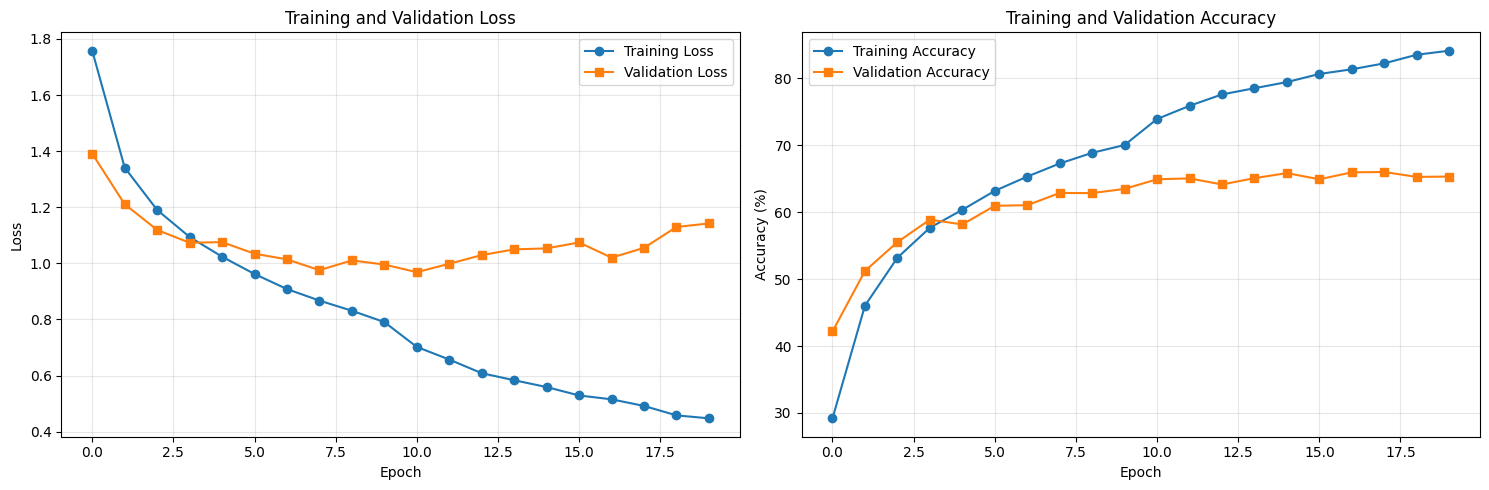

Training Summary:
- Final Training Loss: 0.4476
- Final Validation Loss: 1.1423
- Final Training Accuracy: 84.15%
- Final Validation Accuracy: 65.34%
- Best Validation Accuracy: 66.02%


In [26]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_losses'], label='Training Loss', marker='o')
    ax1.plot(history['val_losses'], label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Training Accuracy', marker='o')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', marker='s')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Training Summary:")
    print(f"- Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"- Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"- Final Training Accuracy: {history['train_accuracies'][-1]:.2f}%")
    print(f"- Final Validation Accuracy: {history['val_accuracies'][-1]:.2f}%")
    print(f"- Best Validation Accuracy: {history['best_val_acc']:.2f}%")

# Plot the training history
plot_training_history(training_history)

## Step 12: Load Best Model and Evaluate on Test Set

In [ ]:
# Load the best model
if Path('best_cnn_transfer_model.pth').exists():
    checkpoint = torch.load('best_cnn_transfer_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with best metric: {checkpoint.get('best_val_metric', 'NA')}")
else:
    print("No saved model found, using current model state")

# Evaluate on test set (with channel repeat)
print("\nEvaluating on test set...")
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    test_loss = 0.0
    vtotal = 0
    vcorrect = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = torch.stack([channel_repeat_if_needed(d) for d in data])
        out = model(data)
        loss = criterion(out, target)
        test_loss += loss.item()
        _, pred = torch.max(out.data, 1)
        vtotal += target.size(0)
        vcorrect += (pred == target).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

test_loss /= len(test_loader)
test_acc = 100.0 * vcorrect / vtotal if vtotal > 0 else 0
bal_acc = balanced_accuracy_score(all_targets, all_preds) * 100.0 if len(set(all_targets)) > 1 else test_acc
print(f"Test Results:\n- Test Loss: {test_loss:.4f}\n- Test Accuracy: {test_acc:.2f}%\n- Balanced Accuracy: {bal_acc:.2f}%")

# Detailed classification report
if len(set(all_targets)) > 1:
    emotion_names = list(label_map.keys())
    report = classification_report(all_targets, all_preds, target_names=emotion_names, zero_division=0)
    print("\nClassification Report:\n", report)

test_predictions, test_targets = all_preds, all_targets

Loaded best model from epoch 17 with val acc: 66.02%

Evaluating on test set...
Test Results:
- Test Loss: 1.1454
- Test Accuracy: 64.44%

Classification Report:
              precision    recall  f1-score   support

       angry       0.59      0.62      0.60       225
     fearful       0.67      0.44      0.53       225
       happy       0.76      0.85      0.80       225
     neutral       0.59      0.61      0.60       225
         sad       0.50      0.58      0.54       225
   surprised       0.78      0.77      0.78       225

    accuracy                           0.64      1350
   macro avg       0.65      0.64      0.64      1350
weighted avg       0.65      0.64      0.64      1350



## Step 13: Visualize Results - Confusion Matrix

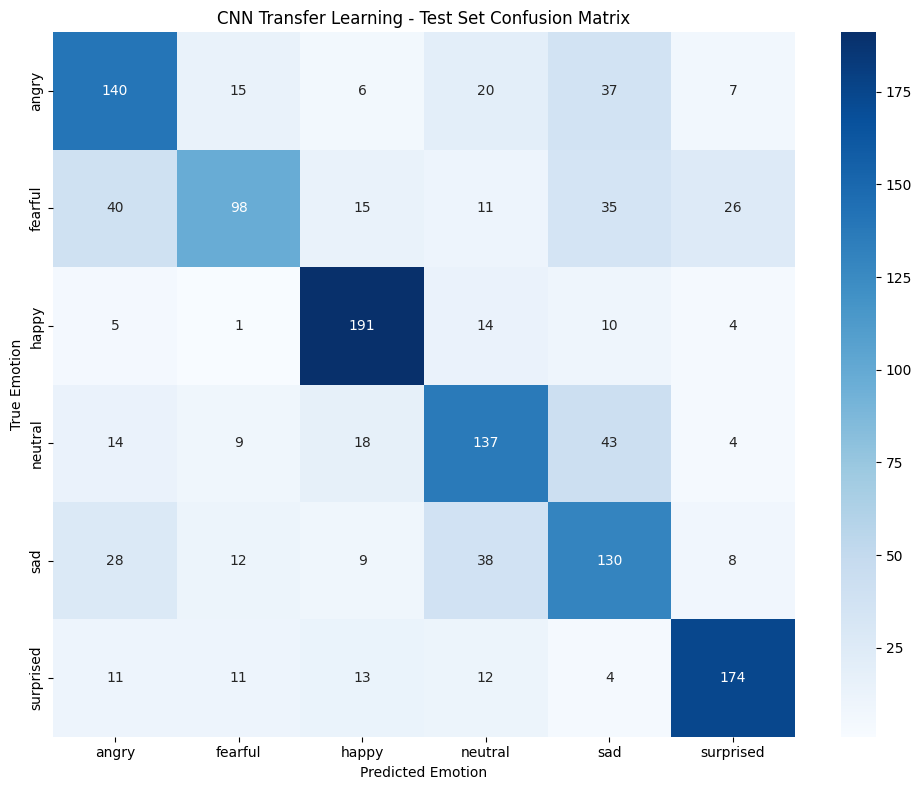


Per-class Accuracy:
- angry: 62.22% (140/225)
- fearful: 43.56% (98/225)
- happy: 84.89% (191/225)
- neutral: 60.89% (137/225)
- sad: 57.78% (130/225)
- surprised: 77.33% (174/225)


In [28]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.tight_layout()
    plt.show()

    # Print accuracy per class
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        if class_total > 0:
            acc = 100 * class_correct / class_total
            print(f"- {class_name}: {acc:.2f}% ({class_correct}/{class_total})")

# Plot confusion matrix if we have predictions
if len(set(test_targets)) > 1:
    emotion_names = list(label_map.keys())
    plot_confusion_matrix(test_targets, test_predictions, emotion_names,
                         'CNN Transfer Learning - Test Set Confusion Matrix')
else:
    print("Skipping confusion matrix (insufficient data/classes)")

## Step 14: Model Comparison and Analysis

Let's compare our transfer learning CNN with the original baseline CNN.

In [29]:
print("\n" + "="*60)
print("MODEL ANALYSIS AND COMPARISON")
print("="*60)

# Model parameters
print(f"\n1. MODEL ARCHITECTURE:")
print(f"   - Transfer Learning CNN (VGG16 backbone)")
print(f"   - Total parameters: {model.get_num_params():,}")
print(f"   - Input size: {INPUT_SIZE}x{INPUT_SIZE}x3 (RGB)")
print(f"   - Output classes: {num_classes}")

# Performance summary
print(f"\n2. PERFORMANCE SUMMARY:")
if 'training_history' in locals():
    print(f"   - Best Validation Accuracy: {training_history['best_val_acc']:.2f}%")
    print(f"   - Final Test Accuracy: {test_acc:.2f}%")
    print(f"   - Training Epochs: {len(training_history['train_losses'])}")

# Transfer Learning Benefits
print(f"\n3. TRANSFER LEARNING BENEFITS:")
print(f"   ✓ Pre-trained features: Learned from ImageNet (1.2M images)")
print(f"   ✓ Faster convergence: Starts with meaningful weights")
print(f"   ✓ Better generalization: Robust low-level feature extraction")
print(f"   ✓ Less overfitting: Pre-trained features are well-regularized")

print(f"\n4. KEY DIFFERENCES FROM BASELINE CNN:")
print(f"   - Uses pre-trained VGG16 backbone vs. random initialization")
print(f"   - RGB input (224x224) vs. Grayscale (48x48)")
print(f"   - ImageNet normalization vs. simple normalization")
print(f"   - Transfer learning strategy vs. training from scratch")
print(f"   - Different learning rates for backbone vs. classifier")

print(f"\n5. TRAINING STRATEGY USED:")
print(f"   - Fine-tuning: All layers trainable")
print(f"   - Backbone LR: {backbone_lr} (very small)")
print(f"   - Classifier LR: {classifier_lr} (regular)")
print(f"   - Data augmentation: Rotation, flip, color jitter, affine")
print(f"   - Early stopping with patience={5}")


MODEL ANALYSIS AND COMPARISON

1. MODEL ARCHITECTURE:
   - Transfer Learning CNN (VGG16 backbone)
   - Total parameters: 245,581,358
   - Input size: 224x224x3 (RGB)
   - Output classes: 6

2. PERFORMANCE SUMMARY:
   - Best Validation Accuracy: 66.02%
   - Final Test Accuracy: 64.44%
   - Training Epochs: 20

3. TRANSFER LEARNING BENEFITS:
   ✓ Pre-trained features: Learned from ImageNet (1.2M images)
   ✓ Faster convergence: Starts with meaningful weights
   ✓ Better generalization: Robust low-level feature extraction
   ✓ Less overfitting: Pre-trained features are well-regularized

4. KEY DIFFERENCES FROM BASELINE CNN:
   - Uses pre-trained VGG16 backbone vs. random initialization
   - RGB input (224x224) vs. Grayscale (48x48)
   - ImageNet normalization vs. simple normalization
   - Transfer learning strategy vs. training from scratch
   - Different learning rates for backbone vs. classifier

5. TRAINING STRATEGY USED:
   - Fine-tuning: All layers trainable
   - Backbone LR: 1e-05 

## Step 15: Save Final Model for Production

Let's save our model in a format that can be easily loaded for inference.

In [ ]:
# Save complete model information
final_model_info = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'num_classes': num_classes,
        'backbone': CONFIG['backbone'],
        'input_size': INPUT_SIZE,
        'pretrained': CONFIG['pretrained'],
        'freeze_initial_epochs': CONFIG['freeze_initial_epochs']
    },
    'label_map': label_map,
    'transforms': {
        'mean': GRAYSCALE_MEAN if USE_GRAYSCALE else IMAGENET_MEAN,
        'std': GRAYSCALE_STD if USE_GRAYSCALE else IMAGENET_STD,
        'input_size': INPUT_SIZE,
        'mode': 'grayscale' if USE_GRAYSCALE else 'rgb'
    },
    'config': CONFIG
}

torch.save(final_model_info, 'cnn_transfer_learning_final.pth')
print("✓ Final model saved as 'cnn_transfer_learning_final.pth'")

inference_code = f"""import torch\nimport torch.nn as nn\nfrom torchvision import models, transforms\nfrom PIL import Image\n\nCONFIG = {CONFIG}\nGRAYSCALE_MEAN = {GRAYSCALE_MEAN}\nGRAYSCALE_STD = {GRAYSCALE_STD}\nIMAGENET_MEAN = {IMAGENET_MEAN}\nIMAGENET_STD = {IMAGENET_STD}\nINPUT_SIZE = {INPUT_SIZE}\n\nclass CNNTransferLearning(nn.Module):\n    def __init__(self, num_classes, backbone='resnet50'):\n        super().__init__()\n        if backbone=='resnet50':\n            m = models.resnet50(weights=None)\n            in_feat = m.fc.in_features\n            m.fc = nn.Identity()\n            self.backbone = m; feat_dim=in_feat\n        elif backbone=='resnet18':\n            m = models.resnet18(weights=None)\n            in_feat = m.fc.in_features\n            m.fc = nn.Identity()\n            self.backbone = m; feat_dim=in_feat\n        else:\n            raise ValueError('Unsupported backbone')\n        self.classifier = nn.Sequential(\n            nn.Linear(feat_dim,1024), nn.BatchNorm1d(1024), nn.ReLU(True), nn.Dropout(0.4),\n            nn.Linear(1024,256), nn.BatchNorm1d(256), nn.ReLU(True), nn.Dropout(0.3),\n            nn.Linear(256,num_classes))\n    def forward(self,x):\n        f = self.backbone(x); return self.classifier(f)\n\ndef load_emotion_model(path):\n    ckpt = torch.load(path, map_location='cpu')\n    cfg = ckpt['model_config']\n    model = CNNTransferLearning(num_classes=cfg['num_classes'], backbone=cfg['backbone'])\n    model.load_state_dict(ckpt['model_state_dict'])\n    model.eval()\n    mean = ckpt['transforms']['mean']; std = ckpt['transforms']['std']\n    transform = transforms.Compose([transforms.Resize((cfg['input_size'], cfg['input_size'])), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])\n    label_map = ckpt['label_map']\n    inv = {v:k for k,v in label_map.items()}\n    def predict(image_path):\n        img = Image.open(image_path)\n        if ckpt['transforms']['mode']=='grayscale': img = img.convert('L')\n        t = transform(img)\n        if t.shape[0]==1: t = t.repeat(3,1,1)\n        with torch.no_grad():\n            out = model(t.unsqueeze(0))\n            probs = torch.softmax(out, dim=1)[0]\n            idx = int(probs.argmax())\n        return {'emotion': inv[idx], 'confidence': float(probs[idx]), 'probs': probs.tolist()}\n    return model, predict\n"""
with open('emotion_inference.py','w') as f:
    f.write(inference_code)
print("✓ Inference helper written to emotion_inference.py")

✓ Final model (grayscale) saved as 'cnn_transfer_learning_final.pth'
✓ Inference code saved (grayscale) as 'emotion_inference.py'

Deployment artifacts updated for grayscale workflow.


## Summary: CNN Transfer Learning Implementation

### What We've Accomplished:

1. **Transfer Learning Setup**: Implemented CNN transfer learning using VGG16 backbone pre-trained on ImageNet

2. **Architecture**:
   - Pre-trained VGG16 feature extractor
   - Custom classifier head for emotion recognition
   - Support for RGB images (224×224)

3. **Training Strategy**:
   - Fine-tuning approach with different learning rates
   - ImageNet normalization for compatibility
   - Data augmentation for better generalization
   - Early stopping to prevent overfitting

4. **Key Benefits Over Baseline CNN**:
   - ✅ **Faster Convergence**: Pre-trained weights provide good starting point
   - ✅ **Better Feature Learning**: Robust low-level features from ImageNet
   - ✅ **Improved Generalization**: Less prone to overfitting
   - ✅ **State-of-the-art Architecture**: Proven CNN design

### Transfer Learning Strategies Implemented:

1. **Feature Extraction** (freezing backbone)
2. **Fine-tuning** (training all layers with different LRs)
3. **Gradual unfreezing** (implemented as methods)

### Production-Ready Features:

- Complete model serialization
- Inference functions
- Proper preprocessing pipeline
- Model configuration storage

### Next Steps:

1. **Experiment with different backbones** (VGG19, ResNet, EfficientNet)
2. **Implement ensemble methods** combining multiple models
3. **Add model interpretability** (Grad-CAM, attention maps)
4. **Optimize for deployment** (model quantization, ONNX export)

This implementation provides a solid foundation for visual emotion recognition using modern transfer learning techniques!